#多个受试者数据一起训练的基准
## 11.02第一次测试

## 第1步：导入、设置与辅助函数

In [1]:
# Cell 1: 导入、设置与辅助函数
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pickle
import os
import time
import pandas as pd
import random
import math
import matplotlib.pyplot as plt # 导入绘图库

def set_seed(seed):
    """设置所有随机种子以确保结果可复现"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    g = torch.Generator()
    g.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # 注意: benchmark = False 可能会轻微牺牲性能，但对可复现性至关重要
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return g

# --- 辅助模块: EEGNet的原始组件 (保持不变) ---
class SeparableConv2d(nn.Module):
    # 可分离卷积 (深度卷积 + 逐点卷积)
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        # 深度卷积
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                     groups=in_channels, bias=bias, padding='same')
        # 逐点卷积
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                     kernel_size=1, bias=bias)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

## 第2步：多受试者 BCI2aDataset

In [2]:
# Cell 2: BCI2aDataset (支持多受试者)
class BCI2aDataset(torch.utils.data.Dataset):
    """
    修改后的数据集类 (Dataset Class)
    - __init__ 接收一个 data_paths 列表 (而不是单个路径)
    - 循环加载并堆叠所有受试者的数据
    - __getitem__ 返回 (eeg_data, action_label, gender, age)
    """
    def __init__(
        self,
        data_paths: list,  # 接收一个路径列表
    ):
        
        all_data = []         # 用于存储所有受试者的 'x' 数据
        all_labels = []       # 用于存储所有受试者的 'y' 标签
        all_genders = []      # 用于存储每个样本的 'gender'
        all_ages = []         # 用于存储每个样本的 'age'

        print("--- 正在加载多受试者数据... ---")
        
        # 遍历您传入的 9 个文件路径
        for data_path in data_paths:
            # --- 提取受试者ID ---
            subjectName = os.path.splitext(os.path.basename(data_path))[0]
            subject_id = int(subjectName[1:3]) - 1

            # --- 加载数据 ---
            with open(data_path, "rb") as f:
                sub_data = pickle.load(f)
            
            # 获取当前文件中的样本数 (例如 288)
            num_samples = len(sub_data['y'])
            
            # --- 收集数据 ---
            all_data.append(sub_data['x'])            # 添加 (288, 22, 512) 的数据
            all_labels.append(sub_data['y'])          # 添加 (288,) 的标签
            
            # (注意) gender 和 age 是受试者级别的，我们需要将其复制 num_samples 次
            all_genders.append(np.repeat(sub_data['gender'], num_samples, axis=0))
            all_ages.append(np.repeat(sub_data['age'], num_samples, axis=0))
            
            print(f"  > 已加载 {subjectName}: {num_samples} 个样本, Subject ID: {subject_id}")

        # --- 将所有数据堆叠成大数组 ---
        self.data = torch.from_numpy(np.concatenate(all_data, axis=0)).type(torch.FloatTensor)
        self.labels = torch.tensor(np.concatenate(all_labels, axis=0), dtype=torch.long) - 1 # (转为 0-3)
        self.genders = torch.tensor(np.concatenate(all_genders, axis=0), dtype=torch.float32)
        self.ages = torch.tensor(np.concatenate(all_ages, axis=0), dtype=torch.float32)
        
        print(f"--- 总计加载 {len(self.labels)} 个样本 ---")
            
    def __len__(self):
        # 返回数据集中样本的总数 (例如 2592)
        return len(self.labels)

    def __getitem__(self, i):
        # 根据索引 i 获取单个数据样本
        # (注意: 这个版本只返回基准模型需要的4个值)
        return self.data[i], self.labels[i], self.genders[i], self.ages[i]

## 第3步：带拼接功能的 EEGNet（基准模型）

In [3]:
# Cell 3: EEGNet (带 Gender+Age 拼接功能)
class EEGNet_Baseline(nn.Module):
    """
    基准模型: EEGNet 编码器 + 拼接 (Gender, Age) + 分类头
    """
    def __init__(self, no_spatial_filters, no_channels, no_temporal_filters, temporal_length_1, temporal_length_2, window_length, num_class, drop_out_ratio=0.50, pooling2=4, pooling3=8):
        super(EEGNet_Baseline, self).__init__()
        self.drop_out_ratio = drop_out_ratio
        
        # --- 第1层: 时间卷积 ---
        self.conv1 = nn.Conv2d(1, no_temporal_filters, (1, temporal_length_1), padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(no_temporal_filters, False)
        
        # --- 第2层: 深度空间卷积 ---
        self.conv2 = nn.Conv2d(no_temporal_filters, no_temporal_filters * no_spatial_filters, (no_channels, 1),
                                 groups=no_temporal_filters, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(no_temporal_filters * no_spatial_filters, False)
        self.pooling2 = nn.AvgPool2d(1, pooling2)
        self.dropout = nn.Dropout(self.drop_out_ratio) # Dropout层
        
        # --- 第3层: 可分离卷积 ---
        self.separableConv2 = SeparableConv2d(no_temporal_filters * no_spatial_filters,
                                              no_temporal_filters * no_spatial_filters, (1, temporal_length_2))
        self.batchnorm3 = nn.BatchNorm2d(no_temporal_filters * no_spatial_filters, False)
        self.pooling3 = nn.AvgPool2d((1, pooling3))
        
        # --- 辅助函数: 自动计算全连接层输入维度 ---
        eeg_random = torch.randn(4, no_channels, window_length)
        # 1. 计算 EEG 特征的维度
        self.eeg_feature_len = self.calc_eeg_features_len(eeg_random)
        
        # 2. 我们要拼接 2 个元数据 (gender + age)
        num_meta_features = 2 
        
        # 3. 最终分类头的输入维度 = EEG特征 + 元数据特征
        total_feature_len = self.eeg_feature_len + num_meta_features
        
        print(f"--- 基准模型初始化 ---")
        print(f"  > EEG 特征维度: {self.eeg_feature_len}")
        print(f"  > 拼接元数据数: {num_meta_features} (Gender, Age)")
        print(f"  > 分类头输入维度: {total_feature_len}")
        
        # 4. 定义分类头
        self.fc1 = nn.Linear(total_feature_len, num_class)


    def calc_eeg_features_len(self, x,):
        """辅助函数: 仅计算 EEG 特征部分的维度"""
        self.eval() # 切换到评估模式
        with torch.no_grad(): # 禁用梯度
            # 完整模拟一次前向传播
            x = torch.unsqueeze(x, 1)
            x = self.conv1(x)
            x = self.batchnorm1(x)
            x = self.conv2(x)
            B, FB, Ch, TL = x.shape
            x = torch.reshape(x, (B, FB * Ch, 1, TL))
            x = nn.functional.elu(self.batchnorm2(x))
            x = self.pooling2(x)
            x = self.dropout(x)
            x = self.separableConv2.forward(x)
            x = nn.functional.elu(self.batchnorm3(x))
            x = self.pooling3(x)
            x = self.dropout(x)
            x = torch.flatten(x, start_dim=1)
            return x.shape[-1] # 返回压平后的长度 (e.g., 512)
            
    def forward(self, x, gender, age):
        """核心: 前向传播"""
        # --- 1. EEG 特征提取 ---
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        B, FB, Ch, TL = x.shape
        x = torch.reshape(x, (B, FB * Ch, 1, TL))
        x = nn.functional.elu(self.batchnorm2(x))
        x = self.pooling2(x)
        x = self.dropout(x)
        x = self.separableConv2.forward(x)
        x = nn.functional.elu(self.batchnorm3(x))
        x = self.pooling3(x)
        x = self.dropout(x)
        
        # (B, 512)
        eeg_features = torch.flatten(x, start_dim=1) 
        
        # --- 2. 拼接 (Gender, Age) ---
        # (B, 512) + (B, 1) + (B, 1) -> (B, 514)
        combined_features = torch.cat([eeg_features, gender, age], dim=-1)
        
        # --- 3. 分类 ---
        # (B, 514) -> (B, 4)
        logits = self.fc1(combined_features)
        
        return logits

## 第4步：训练与评估函数（基准版）

In [4]:
# Cell 4: 训练与评估函数 (基准版)

def run_epoch_baseline(loader, train: bool, model, optimizer, criterion, device):
    """
    运行一个完整的 epoch (训练或评估) - 基准版
    """
    if train:
        model.train()  # 设置模型为训练模式
    else:
        model.eval()   # 设置模型为评估模式

    total_loss, total_correct, total_samples = 0.0, 0, 0

    # 启用或禁用梯度计算
    with torch.set_grad_enabled(train):
        # (修改) loader 现在返回 4 个值
        for eeg_data, action_labels, gender, age in loader:
            # --- 数据准备 ---
            x = eeg_data.to(device, non_blocking=True)
            y = action_labels.to(device, non_blocking=True).long() 
            gender = gender.to(device, non_blocking=True)
            age = age.to(device, non_blocking=True)
            
            # (修改) 确保 gender 和 age 是 [B, 1] 形状
            gender = gender.unsqueeze(1) if gender.dim() == 1 else gender
            age = age.unsqueeze(1) if age.dim() == 1 else age


            # --- 训练步骤 ---
            if train:
                optimizer.zero_grad(set_to_none=True)  # 清空梯度

            # --- 前向传播 (修改) ---
            logits = model(x, gender, age) # 只传入 3 个参数
            loss = criterion(logits, y)

            # --- 训练步骤 ---
            if train:
                loss.backward()  # 反向传播
                optimizer.step() # 更新权重

            # --- 统计结果 ---
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1) # 预测的动作 (0-3)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

    # 计算平均损失和准确率
    avg_loss = total_loss / max(total_samples, 1)
    acc = total_correct / max(total_samples, 1)
    return avg_loss, acc

## 第5步：主执行程序（基准版）

In [5]:
# Cell 5: 主执行程序 (基准版)

# --- 1. 设置参数 ---
SEED_VALUE = 42
# --- (关键修改) ---
BASE_PATH = "/lustre1/project/stg_00160/EEG_LLM/" # [!!!] 您的 .pkl 文件基础路径
# --- (修改结束) ---

# --- 训练超参数 ---
batch_size = 32
epochs = 100
lr = 1e-3
weight_decay = 1e-4
num_workers = 0 # 保持为 0 以确保可复现性

# --- 2. 准备工作 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loader_generator = set_seed(SEED_VALUE) # 设置随机种子
print(f"--- 正在 {device} 上运行 (基准模型) ---")

# --- 3. 加载数据 ---
# --- (关键修改) 构建所有9个受试者的文件路径列表 ---
num_subjects_to_load = 9 # 加载全部 9 个
train_paths = [os.path.join(BASE_PATH, f"A{i:02d}T.pkl") for i in range(1, num_subjects_to_load + 1)]
test_paths = [os.path.join(BASE_PATH, f"A{i:02d}E.pkl") for i in range(1, num_subjects_to_load + 1)]
# --- (修改结束) ---

# 实例化多受试者数据集 (使用 Cell 2 的新 Dataset)
train_dataset = BCI2aDataset(data_paths=train_paths)
test_dataset = BCI2aDataset(data_paths=test_paths)

print(f"训练数据: {len(train_dataset)} 样本")
print(f"测试数据: {len(test_dataset)} 样本")

# 实例化数据加载器
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, drop_last=True, 
    generator=data_loader_generator
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, drop_last=False
)

# --- 4. 实例化模型和优化器 ---
# (修改) 实例化 EEGNet_Baseline 模型
model = EEGNet_Baseline(
    no_spatial_filters=4, no_channels=22, no_temporal_filters=8,
    temporal_length_1=64, temporal_length_2=16, 
    window_length=int(4*128), # 512
    num_class=4, # 4个动作类别
    drop_out_ratio=0.5
).to(device)

# 定义损失函数和优化器 (标准)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# --- 5. 开始训练 ---
best_test_acc = 0.0
print(f"\n--- 开始 基准模型 训练 (共 {epochs} 轮) ---")

# (用于绘图的历史记录列表)
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(1, epochs + 1):
    
    # (修改) 调用新的 run_epoch_baseline 函数
    train_loss, train_acc = run_epoch_baseline(train_loader, train=True, 
                                               model=model, optimizer=optimizer, 
                                               criterion=criterion, device=device)
    
    test_loss, test_acc = run_epoch_baseline(test_loader, train=False, 
                                             model=model, optimizer=optimizer, 
                                             criterion=criterion, device=device)
    
    # (存储历史记录)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc) # (注意：train_acc 是过拟合的，绘图时主要看 test_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # (保存最佳模型)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save({'model': model.state_dict()}, 'baseline_best_model.pt') # 保存为不同的文件名

    # (打印日志)
    print(
        f"Epoch {epoch:03d} | "
        f"train_loss: {train_loss:.4f}  train_acc: {train_acc*100:.2f}% | "
        f"test_loss: {test_loss:.4f}   test_acc: {test_acc*100:.2f}%"
    )

print(f"\n--- 训练完成 ---")
print(f"最佳测试准确率 (Baseline): {best_test_acc*100:.2f}%")

# (保存CSV)
history_df = pd.DataFrame({
    "epoch": range(1, epochs + 1),
    "train_loss": train_loss_history,
    "train_acc": train_acc_history,
    "test_loss": test_loss_history,
    "test_acc": test_acc_history
})
history_df.to_csv("baseline_training_history.csv", index=False)
print("已保存训练曲线到 baseline_training_history.csv")

--- 正在 cuda 上运行 (基准模型) ---
--- 正在加载多受试者数据... ---
  > 已加载 A01T: 288 个样本, Subject ID: 0
  > 已加载 A02T: 288 个样本, Subject ID: 1
  > 已加载 A03T: 288 个样本, Subject ID: 2
  > 已加载 A04T: 288 个样本, Subject ID: 3
  > 已加载 A05T: 288 个样本, Subject ID: 4
  > 已加载 A06T: 288 个样本, Subject ID: 5
  > 已加载 A07T: 288 个样本, Subject ID: 6
  > 已加载 A08T: 288 个样本, Subject ID: 7
  > 已加载 A09T: 288 个样本, Subject ID: 8
--- 总计加载 2592 个样本 ---
--- 正在加载多受试者数据... ---
  > 已加载 A01E: 288 个样本, Subject ID: 0
  > 已加载 A02E: 288 个样本, Subject ID: 1
  > 已加载 A03E: 288 个样本, Subject ID: 2
  > 已加载 A04E: 288 个样本, Subject ID: 3
  > 已加载 A05E: 288 个样本, Subject ID: 4
  > 已加载 A06E: 288 个样本, Subject ID: 5
  > 已加载 A07E: 288 个样本, Subject ID: 6
  > 已加载 A08E: 288 个样本, Subject ID: 7
  > 已加载 A09E: 288 个样本, Subject ID: 8
--- 总计加载 2592 个样本 ---
训练数据: 2592 样本
测试数据: 2592 样本


/data/leuven/379/vsc37996/miniconda3/envs/test1/lib/python3.11/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


--- 基准模型初始化 ---
  > EEG 特征维度: 512
  > 拼接元数据数: 2 (Gender, Age)
  > 分类头输入维度: 514

--- 开始 基准模型 训练 (共 100 轮) ---
Epoch 001 | train_loss: 1.4064  train_acc: 27.70% | test_loss: 1.3387   test_acc: 35.19%
Epoch 002 | train_loss: 1.2826  train_acc: 40.59% | test_loss: 1.2640   test_acc: 41.47%
Epoch 003 | train_loss: 1.2124  train_acc: 45.95% | test_loss: 1.2451   test_acc: 43.33%
Epoch 004 | train_loss: 1.1829  train_acc: 47.15% | test_loss: 1.1928   test_acc: 49.19%
Epoch 005 | train_loss: 1.1402  train_acc: 50.96% | test_loss: 1.1675   test_acc: 50.62%
Epoch 006 | train_loss: 1.1165  train_acc: 51.62% | test_loss: 1.1714   test_acc: 49.85%
Epoch 007 | train_loss: 1.0969  train_acc: 53.05% | test_loss: 1.1381   test_acc: 52.66%
Epoch 008 | train_loss: 1.0596  train_acc: 55.13% | test_loss: 1.1172   test_acc: 53.51%
Epoch 009 | train_loss: 1.0472  train_acc: 55.36% | test_loss: 1.0851   test_acc: 55.09%
Epoch 010 | train_loss: 1.0327  train_acc: 56.44% | test_loss: 1.0753   test_acc: 55.25%
E

## 第6步：绘制训练曲线（基准版）

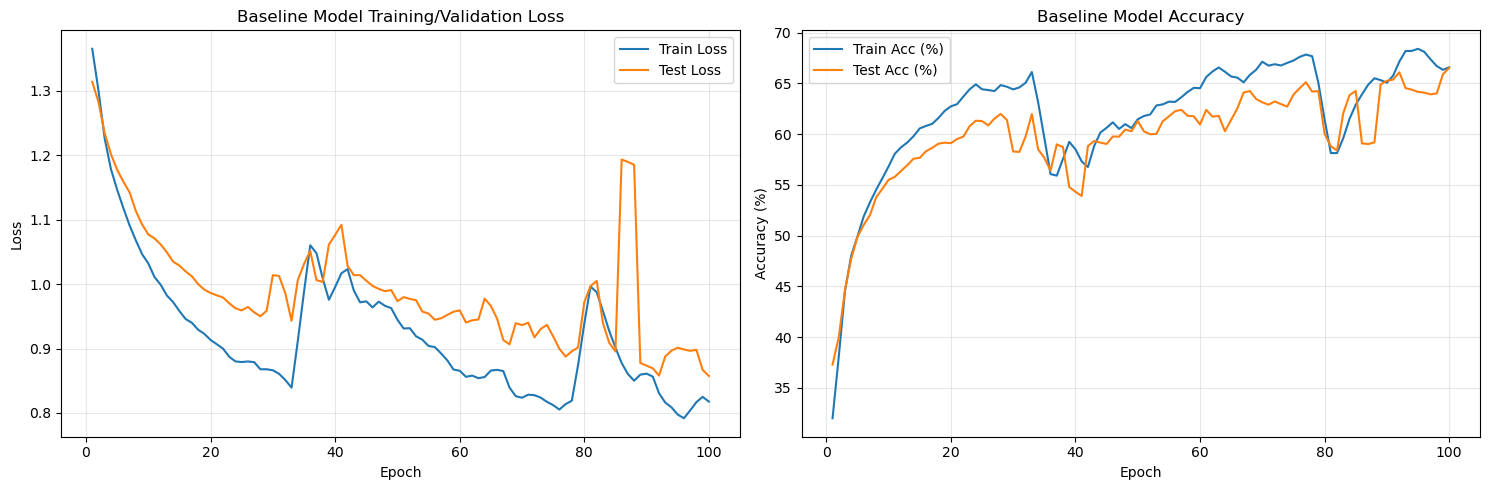

In [6]:
# Cell 6: 绘制训练曲线 (基准版)

# 读取训练历史
df = pd.read_csv("baseline_training_history.csv")

# (定义平滑函数)
def smooth(y, k=5):
    if k <= 1: return y
    kernel = np.ones(k) / k
    pad = k // 2
    y_pad = np.pad(y, (pad, pad), mode='edge')
    y_smooth = np.convolve(y_pad, kernel, mode='valid')
    return y_smooth

k = 3 # 平滑窗口

# 1) Loss 曲线
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1) # 子图1
plt.plot(df["epoch"], smooth(df["train_loss"].values, k), label="Train Loss")
plt.plot(df["epoch"], smooth(df["test_loss"].values,  k), label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model Training/Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# 2) Accuracy 曲线
plt.subplot(1, 2, 2) # 子图2
# (我们只关心 Test Acc，但也可以画 Train Acc 来观察过拟合)
plt.plot(df["epoch"], smooth((df["train_acc"].values*100), k), label="Train Acc (%)")
plt.plot(df["epoch"], smooth((df["test_acc"].values*100), k), label="Test Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Baseline Model Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()